# First Test: Median filter with real data.

## DW (2015.11.23)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, triang
import sys
# Add a new path with needed .py files.
sys.path.insert(0, 'C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\MedianFilter\Python') 

import functions
import gitInformation
import nlxio

In [2]:
%matplotlib inline

In [3]:
gitInformation.printInformation()

Information about this notebook
Date: 2015-12-02
Python Version: 2.7.10 |Anaconda 2.4.0 (32-bit)| (default, Nov  7 2015, 13:29:20) [MSC v.1500 32 bit (Intel)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: 5fa371a19ad88df4b8751d152211c5012ec7e007
Remotes: fork, origin, 
Current branch: master
fork remote URL: http://github.com/dowa4213/kt-2015-DSPHandsOn.git
origin remote URL: https://github.com/ktakagaki/kt-2015-DSPHandsOn.git


### Figure 1. Real Data

In [4]:
# Load some .ncs(neuralynx continuous sample file) data with nlxio
# nlxio taken from https://github.com/bwillers/nlxio
csc = nlxio.loadNcs('CSC2_2906536002_2913013352.ncs', should_read_time = False)

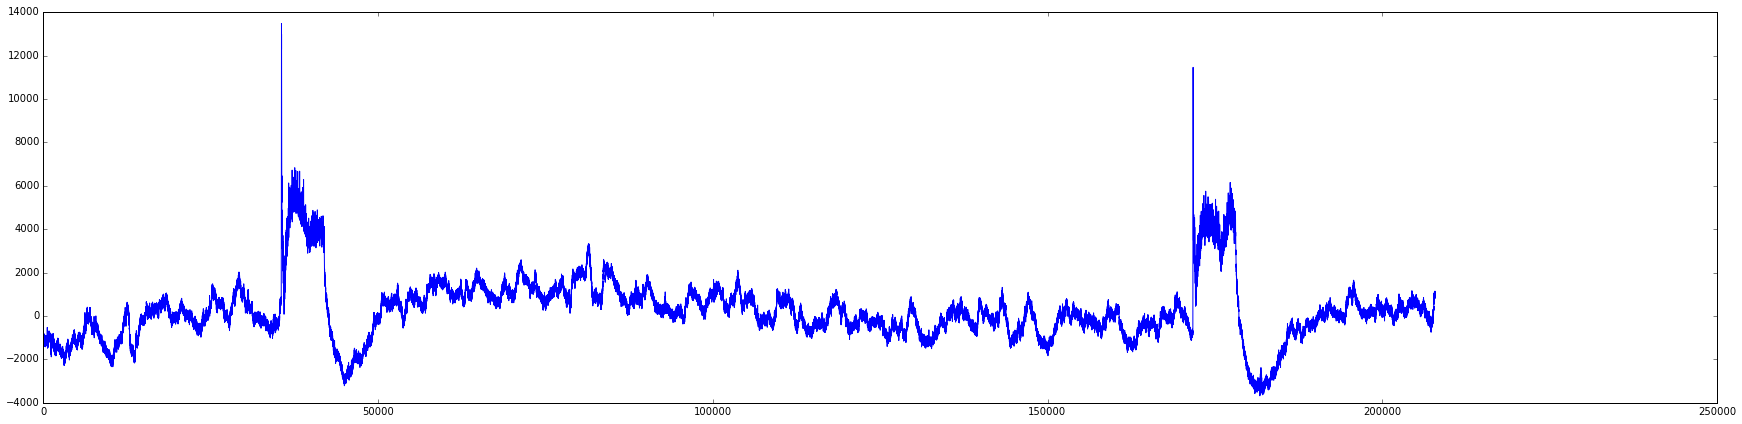

In [5]:
plt.figure(figsize=(30,7))
plt.plot(csc)

In [6]:
type(csc)

numpy.ndarray

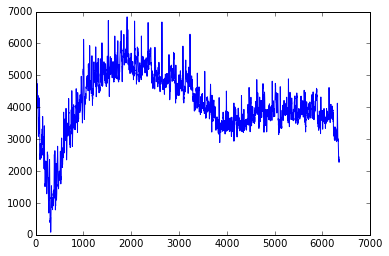

In [7]:
plt.plot(csc[35650:42000])

In [29]:
# Testing the median filter with some different window lengths.
wl = [71, 81, 91, 101, 111]

0
0
0
1
1


In [21]:
filtered = np.zeros((len(csc), len(wl)))

In [22]:
count = -1
for w in wl:
    count = count + 1
    # Median filter the csc data.
    filtered[:,count] = medfilt(csc, w)
np.savetxt("filtereddata.txt", filtered)

In [23]:
filtered = np.loadtxt('filtereddata.txt')

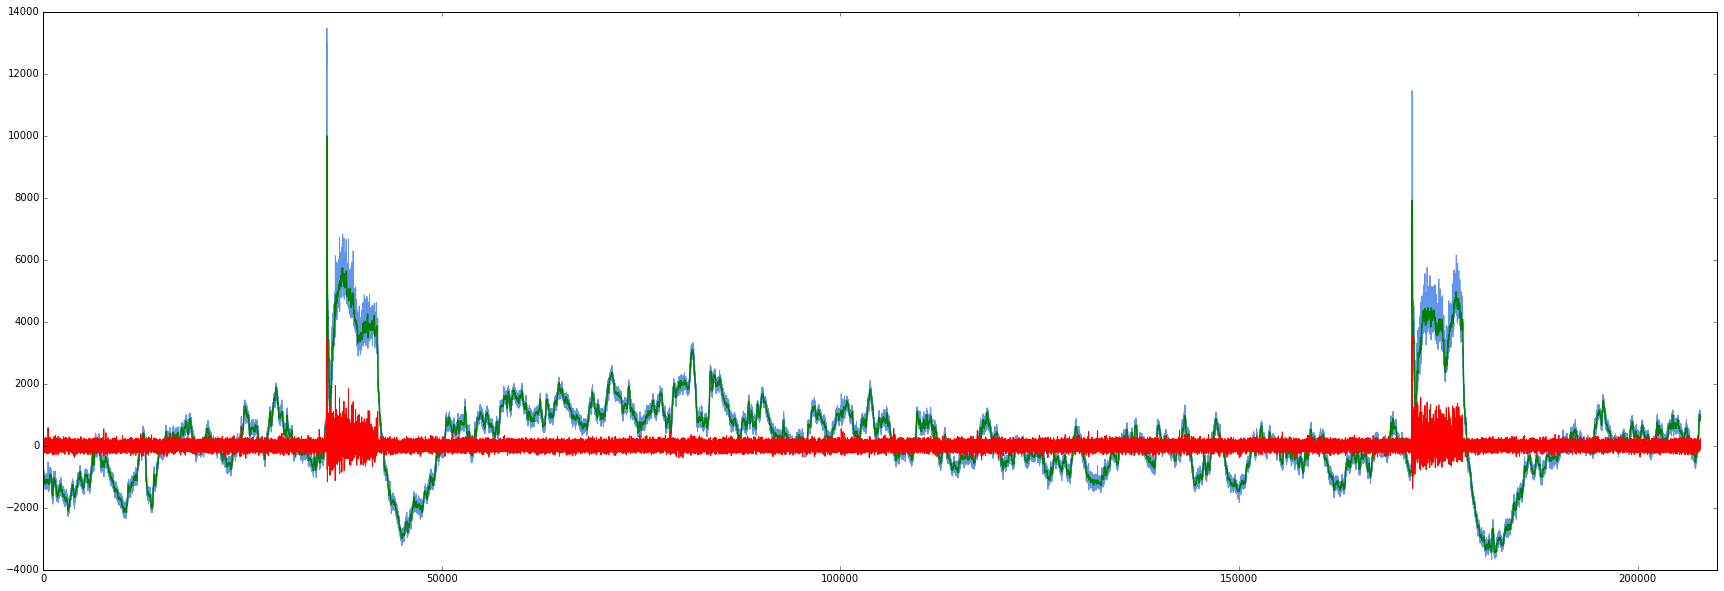

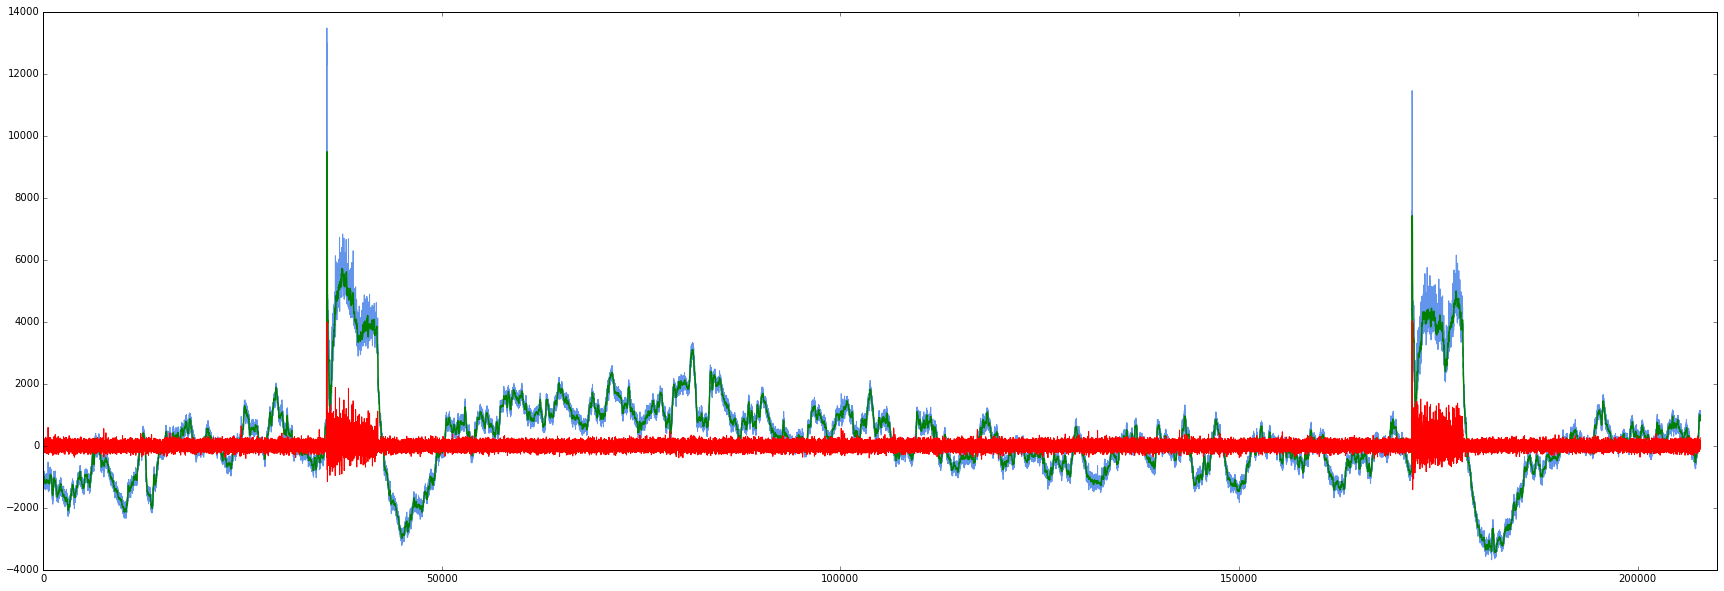

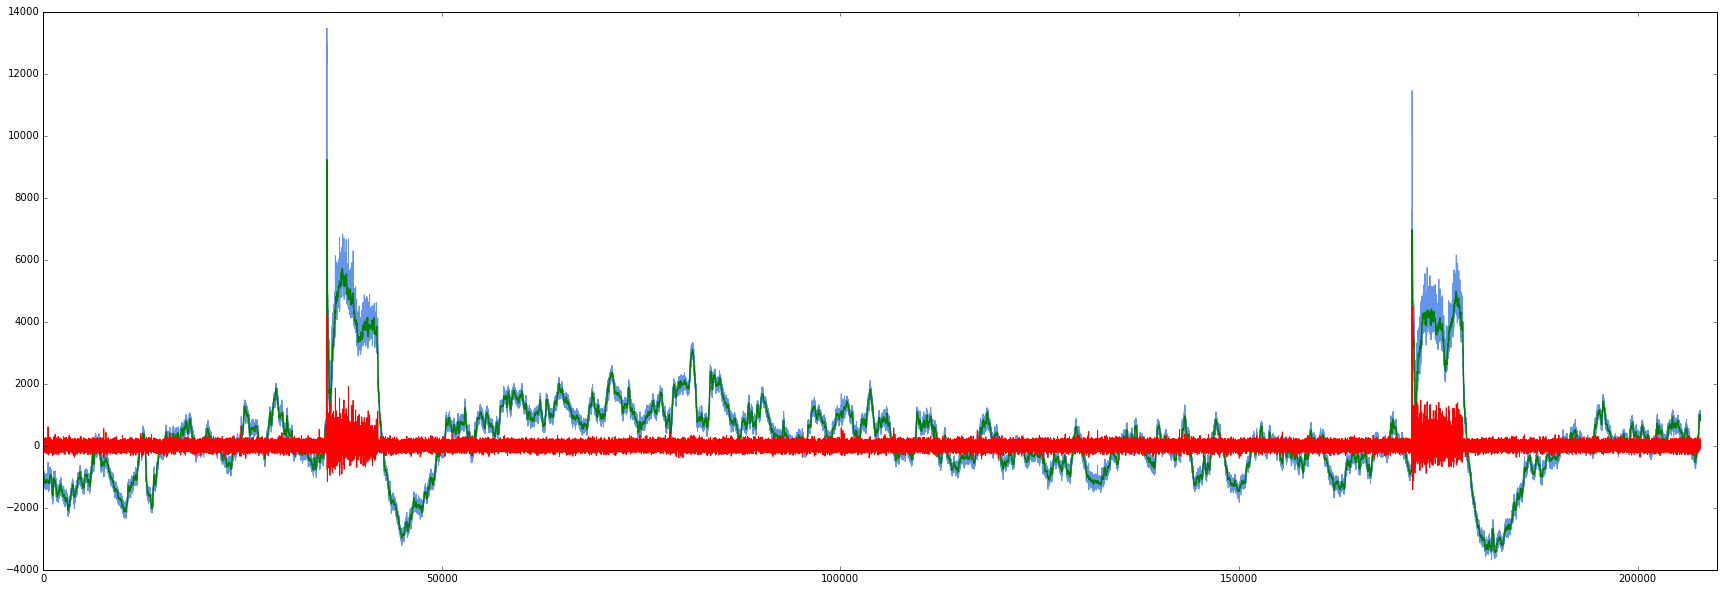

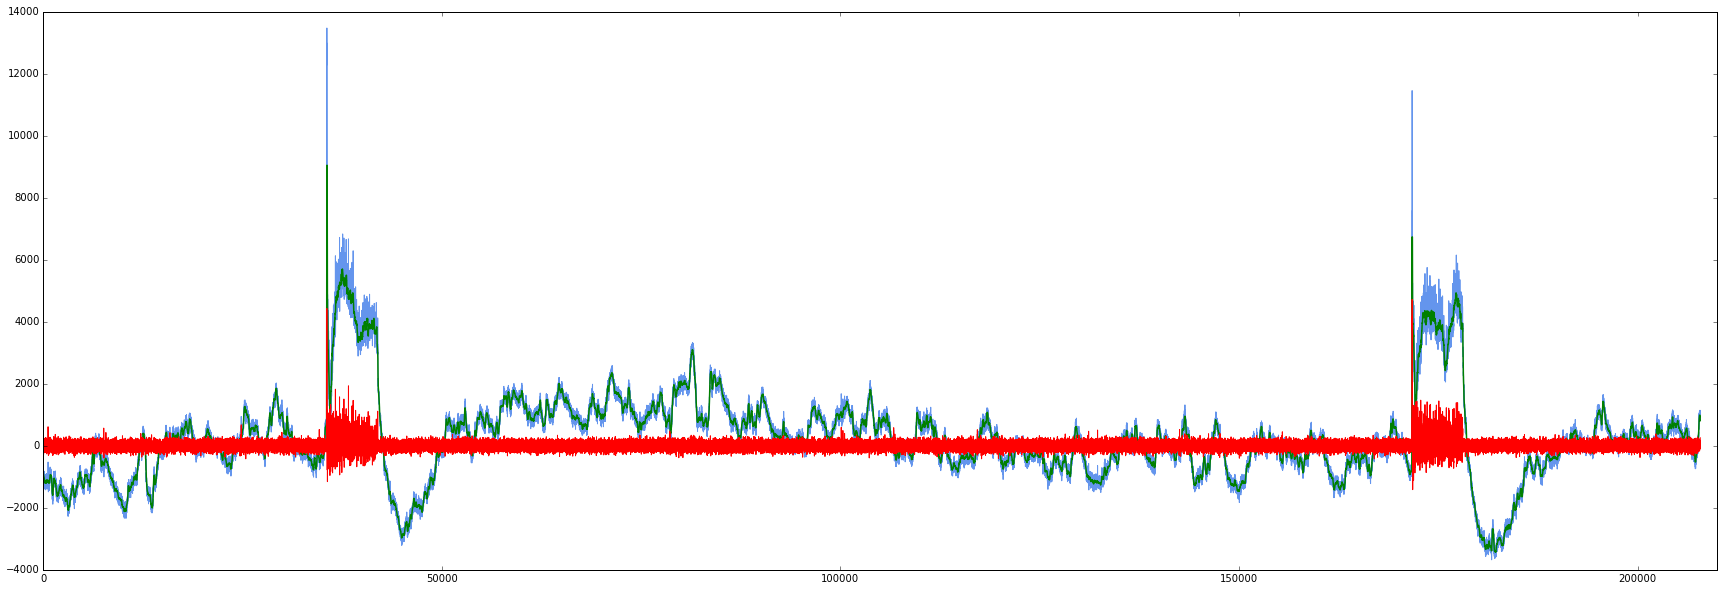

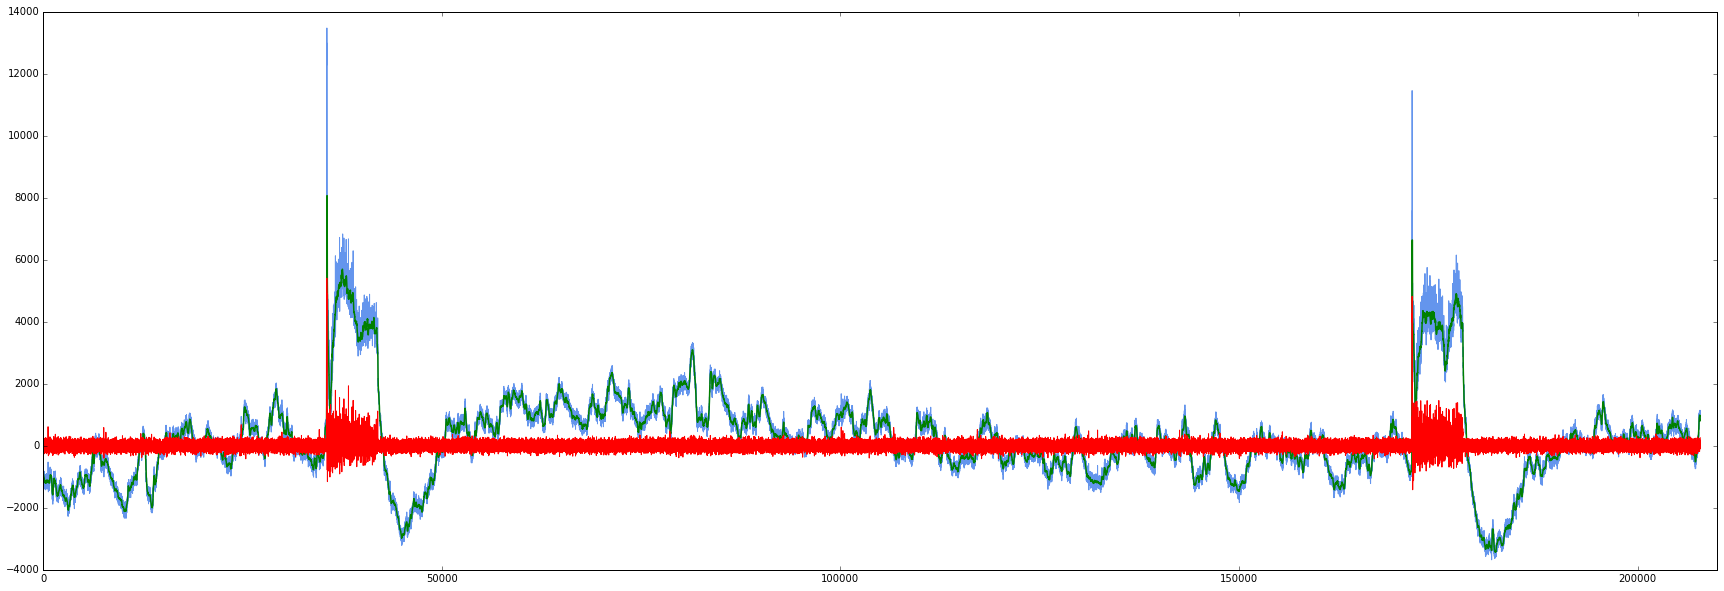

In [24]:
count = 0
for p in range(5):
    count = count + 1
    plt.figure(count, figsize=(30,10))
    plt.axis([0,210000, -4000,14000])
    plt.plot(csc, color = 'cornflowerblue')
    plt.plot(filtered[:,p], color = 'g', lw = 1.5)
    plt.plot(csc-filtered[:,p], color = 'r')

In [13]:
filtered = medfilt(csc, 91)

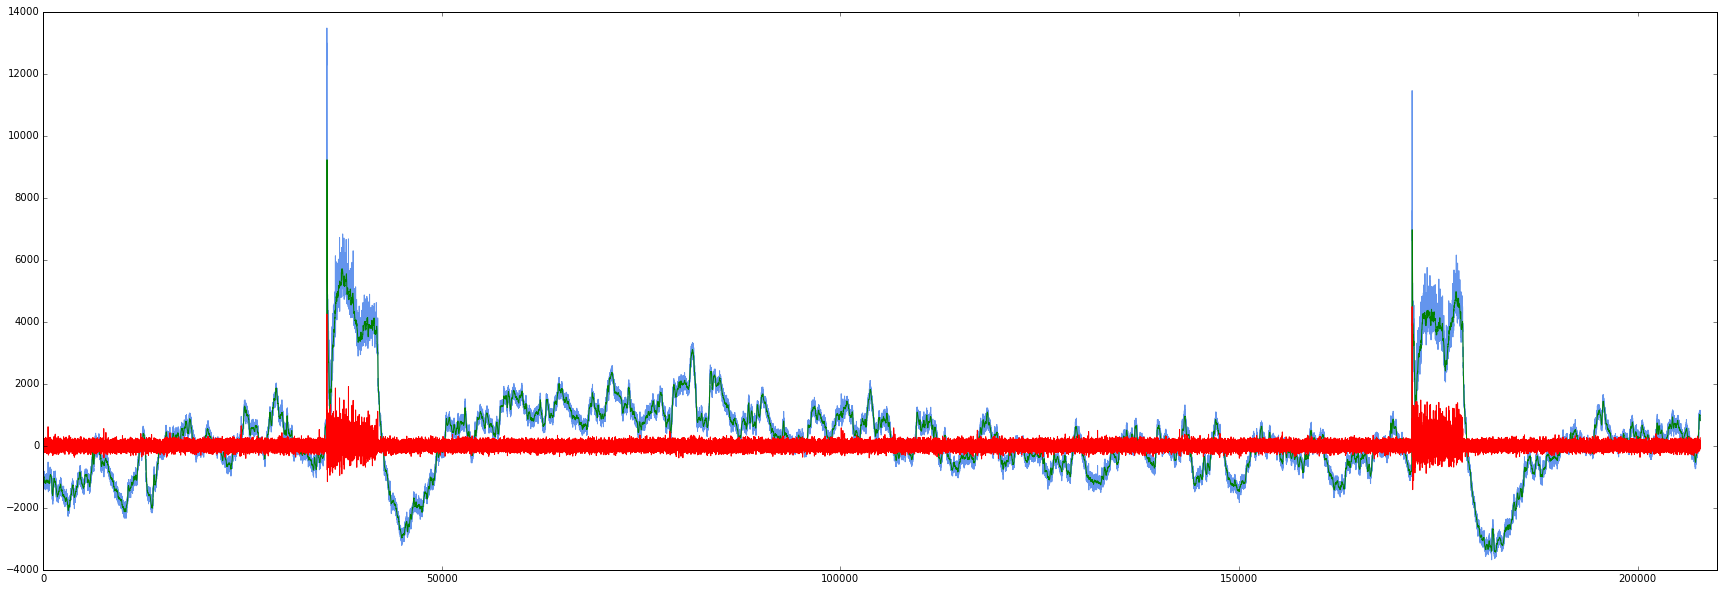

In [14]:
plt.figure(figsize=(30,10))
plt.axis([0,210000, -4000,14000])
plt.plot(csc, color ='cornflowerblue')
plt.plot(filtered, color = 'g')
plt.plot(csc-filtered, color = 'r')

In [15]:
filtered= csc - filtered

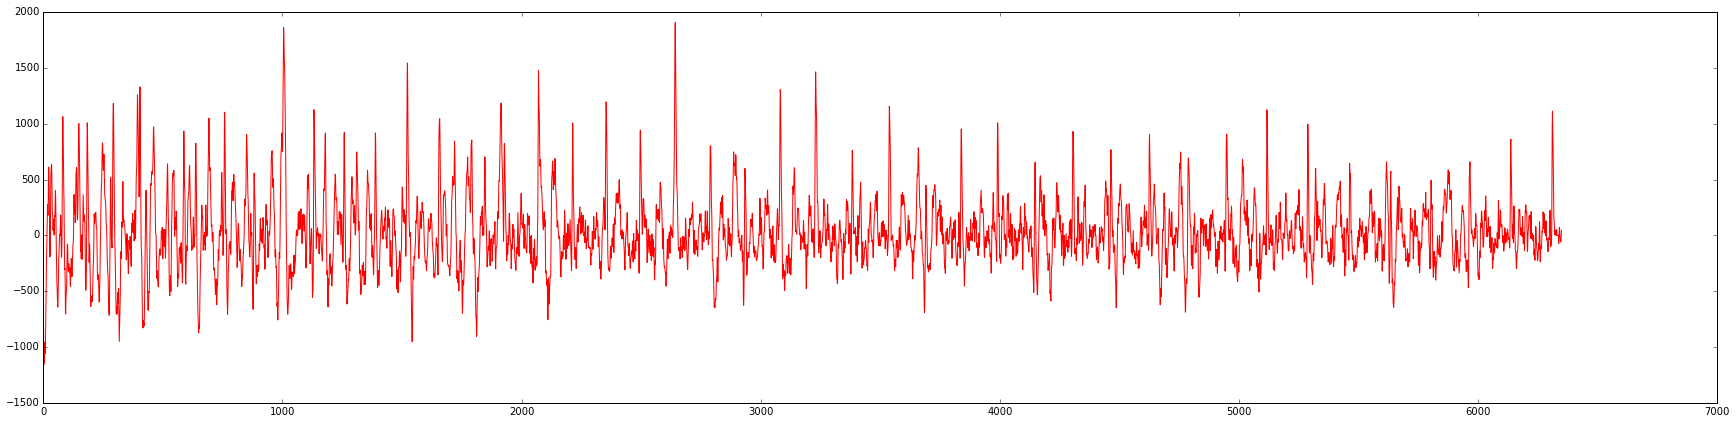

In [16]:
plt.figure(figsize=(30,7))
plt.plot(filtered[35650:42000], color = 'r')

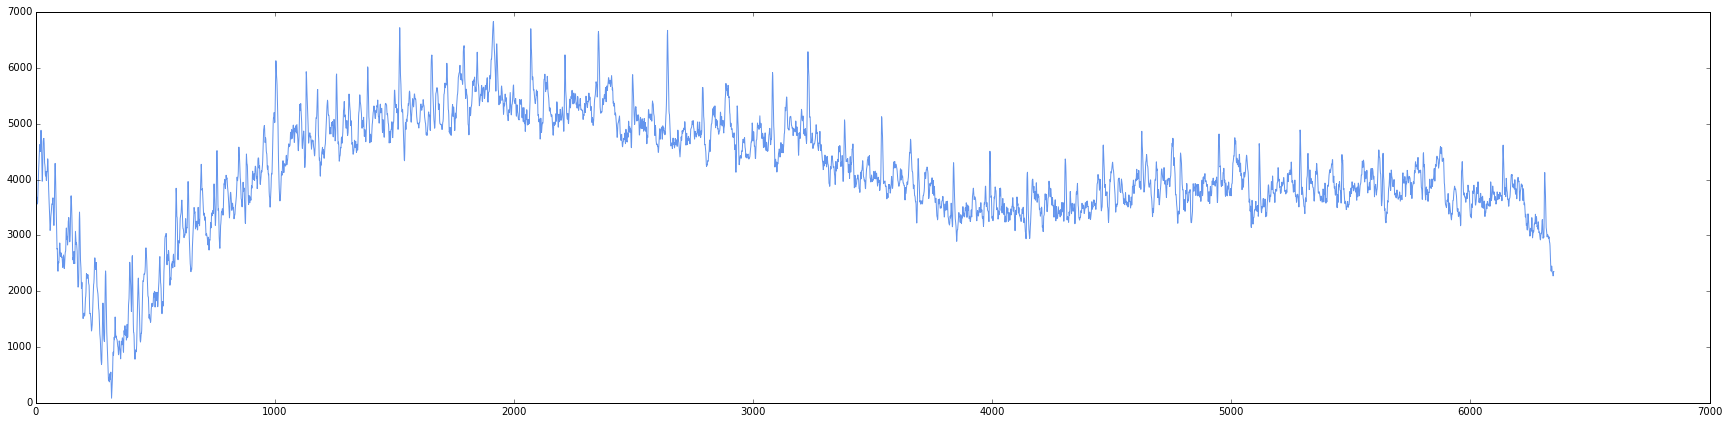

In [20]:
plt.figure(figsize=(30,7))
plt.plot(csc[35650:42000], color = 'cornflowerblue')

## Thresholding

In [51]:
new_data = np.zeros(len(csc))
new_data = csc-filtered[:,3]

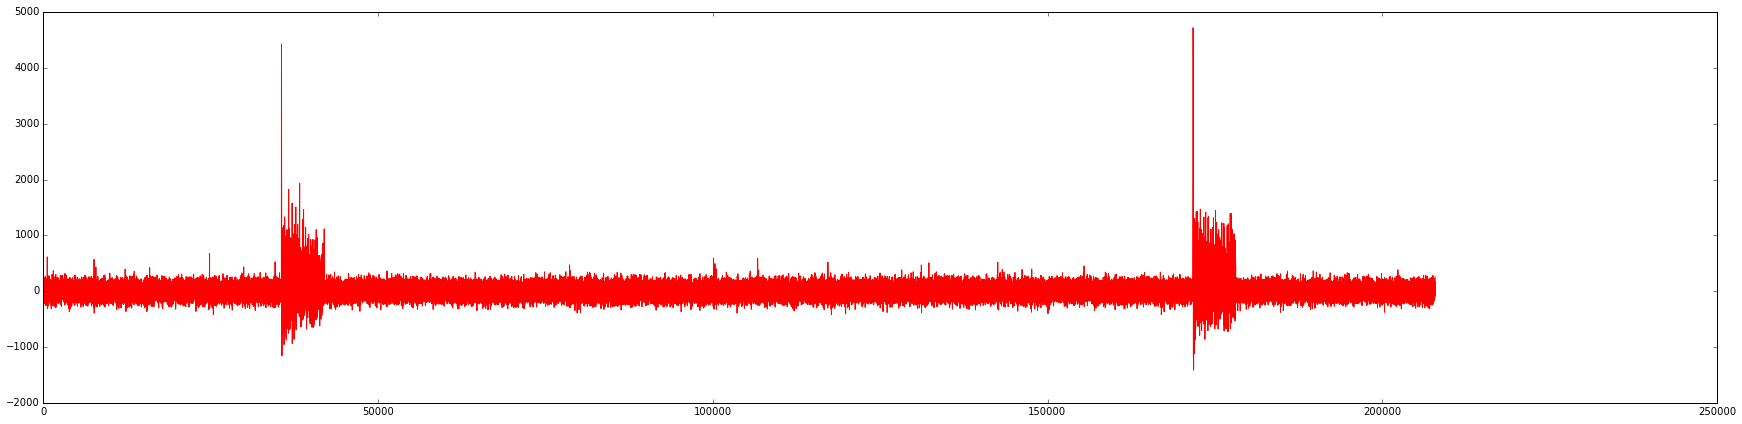

In [304]:
plt.figure(figsize=(30,7))
plt.plot(new_data, color = 'r')

In [315]:
# Declaring counter and and dead time.
# Dead time: if the threshold is reached, we wait 50 samples until the threshhold will be
# activated again
count  = -1
count2 = 0
timer = 0
# Dictionary with all thresholded shapes
thresholds = {}
# Get the value in the new_data array:
for i in new_data:
    # Increment the counter (counter = position in the array)
    count += 1
    # if the value is bigger then 800, the threshold is reached
    if i >= 800:
        # check the thresholded window if some values are bigger then 2500.
        temp = [i for i in new_data[count -20 : count + 30] if i >= 2000]
        # If no values are bigger then 2500 and the dead time is zero,
        # save the window in the dictionary 
        if len(temp) == 0 and timer == 0:
            # set the timer to 50, so 50 samples will be passed
            timer = 50
            # increment count2, for the array name
            count2 += 1
            thresholds["spike{0}".format(count2)] = new_data[count -20 : count + 30]
    elif timer > 0: 
        # Decrement the timer.
        timer -= 1
    else: 
        pass

In [316]:
len(thresholds)

84

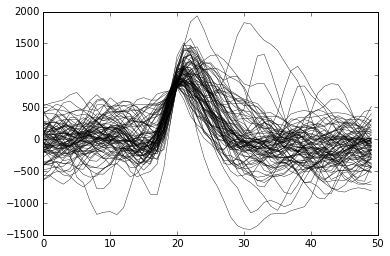

In [317]:
x = np.arange(0,51)
for o in range (1, len(thresholds)):
    plt.plot( thresholds['spike' + str(o)], color = 'black', linewidth = 0.4)